# Battle of Neighborhoods - Week 2 

# Problem: Where to launch a Japanese restaurant in New York City?

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
!pip install folium
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    CLIENT_ID = 'V4AJ5AKTXSCGGTHJHLOIH1WLVJ4QGDYVJJWC25DQICGX5ZWM' # Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='31YRJIR3RZQF2OIZX0KAXWI4UWMZHQAS4KIJJ3XLMAD12CT3' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20200605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [7]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'V4AJ5AKTXSCGGTHJHLOIH1WLVJ4QGDYVJJWC25DQICGX5ZWM'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='31YRJIR3RZQF2OIZX0KAXWI4UWMZHQAS4KIJJ3XLMAD12CT3' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20200605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:
# get new york data
new_york_data=get_new_york_data()

In [10]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
new_york_data.shape

(306, 4)

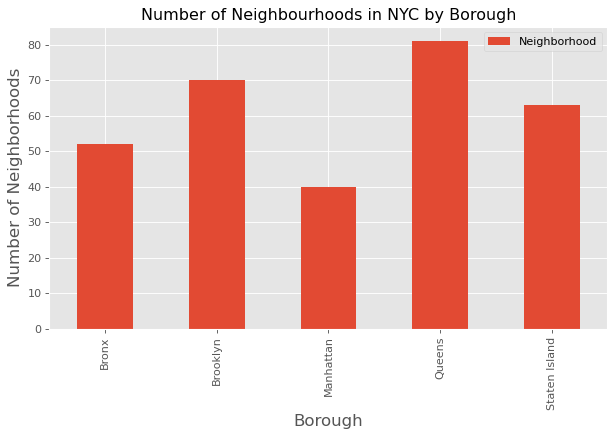

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhoods in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhoods', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [13]:
# prepare neighborhood list that contains japanese restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:0
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

( 138 / 306 ) Japanese Resturants in Richmond Hill, Queens:0
( 139 / 306 ) Japanese Resturants in Flushing, Queens:0
( 140 / 306 ) Japanese Resturants in Long Island City, Queens:0
( 141 / 306 ) Japanese Resturants in Sunnyside, Queens:0
( 142 / 306 ) Japanese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Japanese Resturants in Maspeth, Queens:1
( 144 / 306 ) Japanese Resturants in Ridgewood, Queens:0
( 145 / 306 ) Japanese Resturants in Glendale, Queens:0
( 146 / 306 ) Japanese Resturants in Rego Park, Queens:1
( 147 / 306 ) Japanese Resturants in Woodhaven, Queens:0
( 148 / 306 ) Japanese Resturants in Ozone Park, Queens:0
( 149 / 306 ) Japanese Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Japanese Resturants in College Point, Queens:0
( 151 / 306 ) Japanese Resturants in Whitestone, Queens:0
( 152 / 306 ) Japanese Resturants in Bayside, Queens:0
( 153 / 306 ) Japanese Resturants in Auburndale, Queens:0
( 154 / 306 ) Japanese Resturants in Little Neck, Queens:1
( 155 

( 272 / 306 ) Japanese Resturants in Sutton Place, Manhattan:1
( 273 / 306 ) Japanese Resturants in Hunters Point, Queens:3
( 274 / 306 ) Japanese Resturants in Turtle Bay, Manhattan:3
( 275 / 306 ) Japanese Resturants in Tudor City, Manhattan:1
( 276 / 306 ) Japanese Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Japanese Resturants in Flatiron, Manhattan:4
( 278 / 306 ) Japanese Resturants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Japanese Resturants in Blissville, Queens:0
( 280 / 306 ) Japanese Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Japanese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Japanese Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Japanese Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Japanese Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Japanese Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Japanese Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Japanese Resturants in Sandy Ground, Staten Island:0

In [14]:
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')

In [16]:
japanese_rest_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
85,85,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
86,86,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
87,87,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
88,88,Queens,Sunnyside Gardens,4abebdcbf964a520a78f20e3,Ariyoshi Japanese Restaurant
89,89,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


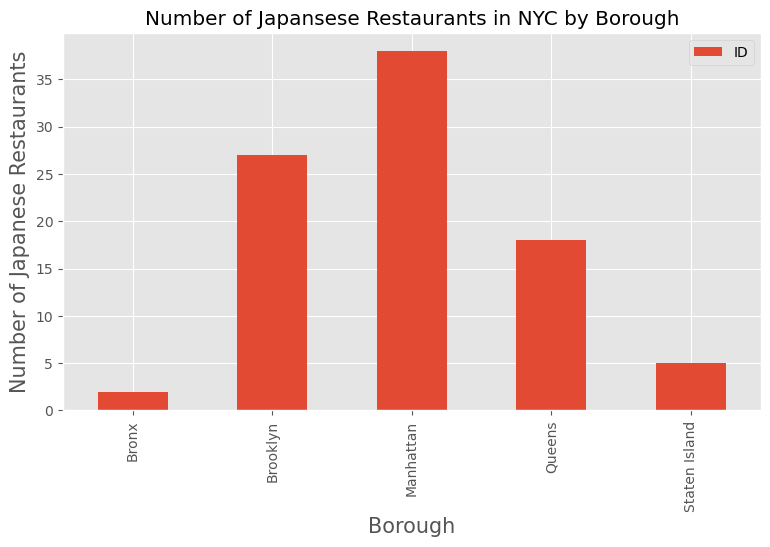

In [18]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japansese Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Japanese Restaurants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Belmont']

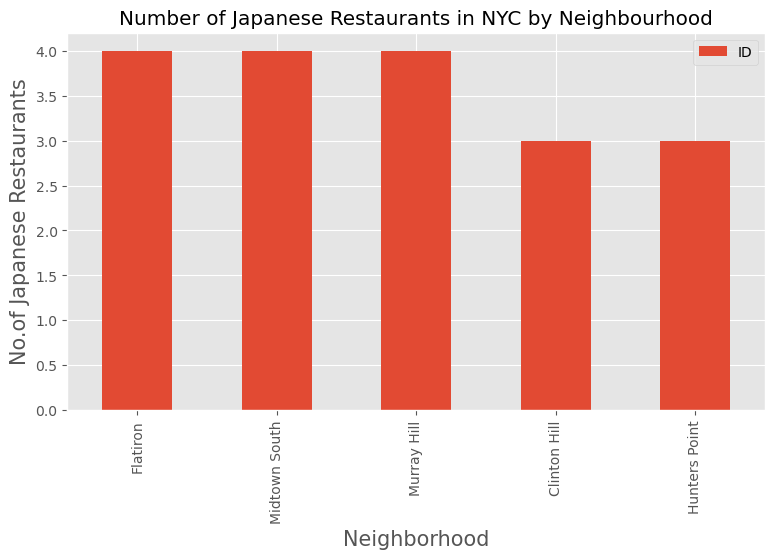

In [19]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Restaurants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [20]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Flatiron']

,Unnamed: 0,Borough,Neighborhood,ID,Name
83,83,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
84,84,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
85,85,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
86,86,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago


In [21]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Midtown South']

,Unnamed: 0,Borough,Neighborhood,ID,Name
66,66,Manhattan,Midtown South,51e8ce40498ea1fb0180efb2,Izakaya MEW
67,67,Manhattan,Midtown South,57ab615d498eef084faa348b,Abiko Curry
68,68,Manhattan,Midtown South,5d7a9d59a369d40008dfcc1a,Konbini
69,69,Manhattan,Midtown South,58b8ed467220e661ddf34104,KazuNori: The Original Hand Roll Bar


In [22]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Unnamed: 0,Borough,Neighborhood,ID,Name
32,32,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
33,33,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
34,34,Manhattan,Murray Hill,48c50c4bf964a520dc511fe3,Café Zaiya
56,56,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


In [29]:
# prepare neighborhood list that contains japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details do not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
    
japanese_rest_stats_ny.tail()

ValueError: too many values to unpack (expected 4)

In [ ]:
japanese_rest_stats_ny.head()

In [ ]:
japanese_rest_stats_ny.shape

In [ ]:
japanese_rest_ny.shape

In [ ]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny.csv', index=False)

In [ ]:
japanese_rest_stats_ny_csv=pd.read_csv('japanese_rest_stats_ny.csv')

In [ ]:
japanese_rest_stats_ny_csv.shape

In [ ]:
japanese_rest_stats_ny_csv.head()

In [ ]:
japanese_rest_stats_ny.info()

In [ ]:
japanese_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')

In [ ]:
japanese_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [ ]:
japanese_rest_stats_ny.info()

In [ ]:
# Restaurants with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

In [ ]:
# Restaurants with maximum Rating
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

In [ ]:
# Restaurants with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

In [ ]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [ ]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

In [ ]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [ ]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Japanese Restaurant in each NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [ ]:
ny_neighborhood_stats

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')